In [1]:
!pip install opendatasets accelerate imblearn --upgrade --quiet

import pandas as pd
import os
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images'
# Using opendatasets let's download the data sets
od.download(dataset)
# # {"username":"kganeshv","key":"224eab20b74a0a68fc7194190f513131"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  pushparajshetty


Your Kaggle Key:

  ············


100%|██████████| 105M/105M [00:03<00:00, 35.1MB/s] 


# Preprocess

In [12]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import accelerate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, Image, ClassLabel
from transformers import TrainingArguments, Trainer, ViTImageProcessor, ViTForImageClassification, DefaultDataCollator
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor
from PIL import ImageFile
from pathlib import Path

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define the list of file names
file_names = []
labels = []
print(len(file_names), len(labels))

0 0


In [14]:
for file in sorted((Path('cifake-real-and-ai-generated-synthetic-images/').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

# Random oversampling of minority class
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

0

In [15]:
df.head()

,image,label
0,cifake-real-and-ai-generated-synthetic-images/...,FAKE
1,cifake-real-and-ai-generated-synthetic-images/...,FAKE
2,cifake-real-and-ai-generated-synthetic-images/...,FAKE
3,cifake-real-and-ai-generated-synthetic-images/...,FAKE
4,cifake-real-and-ai-generated-synthetic-images/...,FAKE


In [16]:
df['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [17]:
# Create a dataset from a Pandas DataFrame
dataset = Dataset.from_pandas(df).cast_column("image", Image())

# Mapping labels to IDs
labels_list = ['REAL', 'FAKE']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [18]:
model_str = "google/vit-base-patch16-224"

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)


In [19]:
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
])

# Define transformations for validation data
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

In [20]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms for the training data
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

# Define a collate function for preparing batched data
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


# Load, train, and evaluate model

In [22]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list),ignore_mismatched_sizes=True)
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate the number of trainable parameters in millions for the model
print(model.num_parameters(only_trainable=True) / 1e6)

# Define the training arguments
num_train_epochs = 2
args = TrainingArguments(
    output_dir="ai_vs_real_image_detection",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=3e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [23]:
# Create a Trainer instance for fine-tuning the model
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    tokenizer=processor,
)

In [24]:
# Evaluate the pre-training model's performance on the test dataset
trainer.evaluate()

{'eval_loss': 0.7560459971427917,
 'eval_runtime': 377.4082,
 'eval_samples_per_second': 127.183,
 'eval_steps_per_second': 1.987}

In [25]:

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.338600,0.568332
2,0.175200,0.548698


TrainOutput(global_step=1126, training_loss=0.24659959545779186, metrics={'train_runtime': 3741.2337, 'train_samples_per_second': 38.49, 'train_steps_per_second': 0.301, 'total_flos': 1.1158846504501248e+19, 'train_loss': 0.24659959545779186, 'epoch': 2.0})

In [26]:

# Evaluate the post-training model's performance on the test dataset
trainer.evaluate()


{'eval_loss': 0.5486980676651001,
 'eval_runtime': 383.7829,
 'eval_samples_per_second': 125.071,
 'eval_steps_per_second': 1.954,
 'epoch': 2.0}

In [27]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.5486980676651001, 'test_runtime': 384.9575, 'test_samples_per_second': 124.689, 'test_steps_per_second': 1.948}


In [28]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

In [29]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Analysis

In [30]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7235
F1 Score: 0.7216


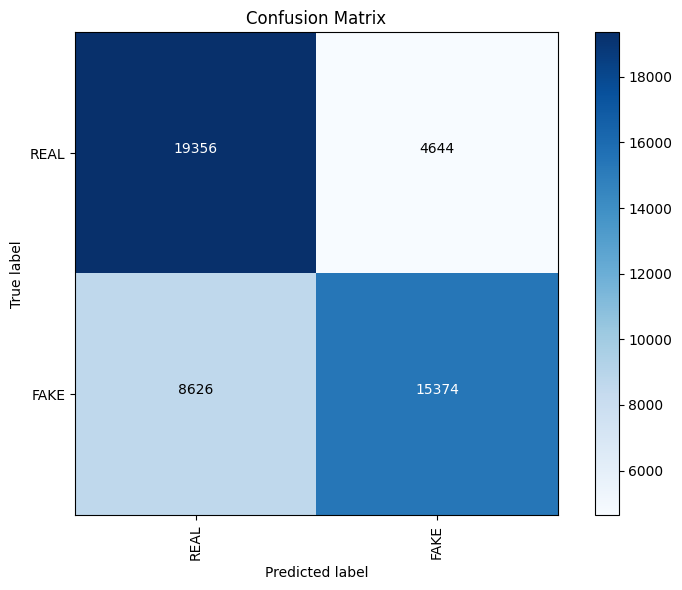

In [31]:
if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))


In [32]:
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

Classification report:
              precision    recall  f1-score   support

        REAL     0.6917    0.8065    0.7447     24000
        FAKE     0.7680    0.6406    0.6985     24000

    accuracy                         0.7235     48000
   macro avg     0.7299    0.7235    0.7216     48000
weighted avg     0.7299    0.7235    0.7216     48000



In [33]:
trainer.save_model()